# Introduction and experiments

In this first notebook, we want to:
- run LLAMA model
- observe its internals (hidden states and attention maps)
- import and read paper author's dataset
- define the SAPLMA classifier as in the original paper

Source: https://arxiv.org/pdf/2304.13734

In [ ]:
import os

# Make this try/except to let this notebook work on Drive but also locally
try:
  from google.colab import drive
  drive.mount('/content/drive')

  DRIVE_PATH = '/content/drive/MyDrive/Final_Project/'
  assert os.path.exists(DRIVE_PATH), 'Did you forget to create a shortcut in MyDrive named Final_Project this time as well? :('
except ModuleNotFoundError:
  DRIVE_PATH = '.'
  assert os.path.abspath(os.getcwd()).split(os.path.sep)[-1] == 'Final_Project'

%cd {DRIVE_PATH}
!pwd
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1WdIP20OinXKeEN_xVOHEa6WVcY4eSO-k/Final_Project
/content/drive/.shortcut-targets-by-id/1WdIP20OinXKeEN_xVOHEa6WVcY4eSO-k/Final_Project
create_saplma_tensors_dataset.ipynb  publicDataset  StudyOnSAPLMA.ipynb


# Install dependencies

In [ ]:
# PyTorch (CPU only, if not installed yet)
try:
    import torch
except ModuleNotFoundError:
    !pip install 'torch>=2.1.1' torchvision --index-url https://download.pytorch.org/whl/cpu

# Huggingface dependencies
!pip install huggingface-hub 'transformers>=4.36' 'accelerate>=0.26.0'

# Visualization dependencies
!pip install matplotlib seaborn ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.5 MB/s eta 0:00:00


# Import and wrap Llama model

In [ ]:
# Initialize the secret for HuggingFace login
import os
try:
    from google.colab import userdata
    # We are in colab, so we should access it from userdata.get(...)
    assert userdata.get('HF_TOKEN'), 'Set up HuggingFace login secret properly in Colab!'
    print('Found HF_TOKEN in Colab secrets')
except ModuleNotFoundError:
    # Not in colab, so we have to setup the token manually reading from a file
    if os.getenv('HF_TOKEN'):
        print('Found HF_TOKEN in environment variables')
    else:
        # Read it from a file
        hf_token_file = '.hf_token'
        assert os.path.exists(hf_token_file), f'You must create a file in this working directory ({os.getcwd()}) called {hf_token_file}, containing the Huggingface personal secret access token'
        with open(hf_token_file, 'r') as f:
            os.environ['HF_TOKEN'] = f.read().strip()
            print('Found HF_TOKEN in file')

Found HF_TOKEN in Colab secrets


In [ ]:
from dataclasses import dataclass
from collections.abc import Iterator
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from tqdm import tqdm

torch.set_default_dtype(torch.float16)

model_name = "meta-llama/Llama-3.2-1B-Instruct" #info at https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class LlamaPrompt:
  """
   Class to represent a prompt for the Llama model, which is made of a system prompt,
   which sets the general context according to which the AI should respond,
   and a user prompt, which is the text that the AI should respond to.
  """
  user_prompt: str
  system_prompt: str

  def __init__(self, user_prompt, system_prompt="You are a helpful AI assistant."):
    self.user_prompt = user_prompt
    self.system_prompt = system_prompt

  def __str__(self) -> str:
      # From: https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#-instruct-model-prompt-
      return ''.join([
          "<|begin_of_text|>",
          f"<|start_header_id|>system<|end_header_id|>{self.system_prompt}<|eot_id|>",
          f"<|start_header_id|>user<|end_header_id|>{self.user_prompt}<|eot_id|>",
          "<|start_header_id|>assistant<|end_header_id|>"
      ])

In [ ]:
@dataclass
class LlamaResponse:
    """
      Class to represent a response given by the Llama model.
    """
    prompt: LlamaPrompt
    response: str

In [ ]:
class LlamaInstruct:
    """
    Class to wrap the Llama model methods for ease of usage
    """
    def __init__(self, model_name: str, model_args: dict = None, tokenizer_args: dict = None, pad_token: str = None):

        self.model_name = model_name
        self.model_args = model_args if model_args is not None else dict()
        self.tokenizer_args = tokenizer_args if tokenizer_args is not None else dict()

        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto", **self.model_args)
        self.model.eval()
        self.device = self.model.device

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left', **self.tokenizer_args)
        self.pad_token = self.tokenizer.eos_token if pad_token is None else pad_token
        self.tokenizer.pad_token = self.pad_token

        self.assistant_header = self.tokenizer.encode("<|start_header_id|>assistant<|end_header_id|>", return_tensors="pt").to(self.device)

        self.registered_hooks = []

    # to tokenize input prompts
    def tokenize(self, prompts: str | LlamaPrompt | list[str | LlamaPrompt]) -> tuple[dict, list[LlamaPrompt]]:

        # Make prompts a list anyway
        if not isinstance(prompts, list):
            print('Converting prompts to a list')
            prompts = [ prompts ]

        # Convert all prompts to LlamaPrompt
        prompts = [ prompt if isinstance(prompt, LlamaPrompt) else LlamaPrompt(prompt) for prompt in prompts ]

        # tokenizer output will be a dictionary of pytorch tensors with keys "input_ids" (numerical ids of tokens)
        # and "attention_mask" (1 for actual input tokens and 0 for padding tokens)
        inputs = self.tokenizer([
            str(prompt) for prompt in prompts
        ], truncation=True, padding=True, return_tensors="pt").to(self.device)

        return inputs, prompts

    # to make Llama generate responses
    def generate(self, inputs: dict, generate_args: dict = None): #-> Iterator[LlamaResponse] ? right now it does not return that

        generate_args = generate_args if generate_args is not None else dict()
        default_args = {
            "max_length": 100,
            "num_return_sequences": 1,
            "temperature": 0.1,
            "pad_token_id": self.tokenizer.pad_token_id,
            "eos_token_id": self.tokenizer.eos_token_id,
        }

        # Overwrite default_args with generate_args
        default_args.update(generate_args)

        # returns (batch_size, sequence_length) tensors with token ids of the generated response, including input tokens
        return self.model.generate(
            **inputs,
            **default_args,
        )

    # to extract Llama answers as decoded text in a LlamaResponse object starting from encoded input
    def extract_responses(self, input_ids: torch.Tensor, outputs: torch.Tensor, prompts: list[LlamaPrompt]) -> Iterator[LlamaResponse]:

        for input, output, prompt in zip(input_ids, outputs, prompts):
            # Remove the prompt from the output generated
            output = output[len(input):]

            # Remove another assistant_header, if present
            if torch.equal(output[:len(self.assistant_header)], self.assistant_header):
                output = output[len(self.assistant_header):]

            generated = self.tokenizer.decode(output, skip_special_tokens=True).strip()

            yield LlamaResponse(prompt, generated)

    # to get textual Llama responses starting from textual prompts
    def run(self, prompts: str | LlamaPrompt | list[str | LlamaPrompt], verbose: bool = False) -> Iterator[LlamaResponse]:

        # Optional logging function
        def _print(*args, **kwargs):
            if verbose:
                print(*args, **kwargs)

        inputs, prompts = self.tokenize(prompts)

        _print('Tokenized inputs:', inputs.input_ids.shape)
        _print('Last tokens:', inputs.input_ids[:, -1])

        outputs = self.generate(inputs)
        _print('Generated outputs:', outputs.shape)

        return self.extract_responses(inputs.input_ids, outputs, prompts)

    # an hook is a piece of customized code to be run in the forward or backward pass of a model
    # (useful for debugging)
    def register_hook(self, module, hook_fn):
        '''
        Register a hook, in such a way that we have a very easy way to remove the hook later.

        Example usage:

        llama.unregister_all_hooks()
        for module_name, module in llama.model.named_modules():
            if something():
                llama.register_hook(module, hook_fn)
        '''
        handle = module.register_forward_hook(hook_fn)
        self.registered_hooks.append(handle)

    def unregister_all_hooks(self):
        '''
        Remove all of our registered hooks.
        '''
        for handle in self.registered_hooks:
            handle.remove()

    def _get_model_num_heads(self) -> int:
        return self.model.config.num_attention_heads

    def _get_model_hidden_layers(self) -> int:
        return self.model.config.num_hidden_layers


In [ ]:
def pretty_print_output(output: LlamaResponse):
    print(f"\n\n==================================")
    print(output.prompt.user_prompt)
    print("=============")
    print(output.response)

# Run Llama model
Do a few little tests

In [ ]:
llama = LlamaInstruct(model_name)#, model_args={"attn_implementation": "eager"})
assert llama.device.type == 'cuda', 'The model should be running on a GPU. On CPU, it is impossible to run'

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
type(llama)

__main__.LlamaInstruct

In [ ]:
list(llama.model.children())[0].layers  # visualize the main stack of layers responsible for processing the input

ModuleList(
  (0-15): 16 x LlamaDecoderLayer(
    (self_attn): LlamaSdpaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=512, bias=False)
      (v_proj): Linear(in_features=2048, out_features=512, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [ ]:
# Sample prompts
prompts = [
    "Explain quantum computing in simple terms.",
    "Write a short poem about artificial intelligence.",
    "Describe the future of renewable energy.",
    "Discuss the impact of machine learning on healthcare."
]

with torch.no_grad():
    for output in llama.run(prompts, verbose=True):
        pretty_print_output(output)

Tokenized inputs: torch.Size([4, 29])
Last tokens: tensor([128007, 128007, 128007, 128007], device='cuda:0')
Generated outputs: torch.Size([4, 100])


Explain quantum computing in simple terms.
Quantum computing is a fascinating field that's still in its early stages, but I'll try to break it down in simple terms.

**What is quantum computing?**

Quantum computing is a new way of processing information that's different from classical computers. Classical computers use "bits" to store and process information, which are either 0 or


Write a short poem about artificial intelligence.
Here is a short poem about artificial intelligence:

In silicon halls, a mind awakes,
A world of code, a digital shakes,
Artificial intelligence, a force so grand,
A future born, with logic's hand.

With algorithms and circuits bright,
It learns and grows, through day and night,
It solves and adapts, with precision fine


Describe the future of renewable energy.
The future of renewable energy is a promising a

# Analyze Llama attention maps

In [ ]:
class LlamaAttentionExtractor:

    def __init__(self, llama: LlamaInstruct):
        """
        Initialize Llama model with hooks to capture attention maps
        """
        self.llama = llama


    def extract_attention_maps(self, prompt, max_length=200, num_return_sequences=5):
        print('Max len:', max_length)
        print('Return sequences:', num_return_sequences)

        # Get the number of head
        print('Llama num_heads:', self.llama._get_model_num_heads())
        print('Llama hidden_layers:', self.llama._get_model_hidden_layers())

        inputs, _ = self.llama.tokenize(prompt)
        print(f'Inputs: {inputs.input_ids.shape}')
        outputs = self.llama.generate(
            inputs,
            generate_args={
                "max_length": max_length,
                "num_return_sequences": num_return_sequences,
                "output_attentions": True,
                "return_dict_in_generate": True,
            }
        )

        return outputs.attentions

extractor = LlamaAttentionExtractor(llama)
prompt = "Hello, how are you? I'm fine, and you?"
attentions = extractor.extract_attention_maps(prompt)

for i, attn in enumerate(attentions):
    print(f'attentions[{i:>2d}][{len(attn)} items]: {type(attn[0])}[{attn[0].shape}]')

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Max len: 200
Return sequences: 5
Llama num_heads: 32
Llama hidden_layers: 16
Converting prompts to a list
Inputs: torch.Size([1, 33])


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


attentions[ 0][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 33, 33])]
attentions[ 1][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 34])]
attentions[ 2][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 35])]
attentions[ 3][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 36])]
attentions[ 4][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 37])]
attentions[ 5][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 38])]
attentions[ 6][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 39])]
attentions[ 7][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 40])]
attentions[ 8][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 41])]
attentions[ 9][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 42])]
attentions[10][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 43])]
attentions[11][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 44])]
attentions[12][16 items]: <class 'torch.Tensor'>[torch.Size([5, 32, 1, 45])

input_attn: <class 'torch.Tensor'>[torch.Size([33, 33])]


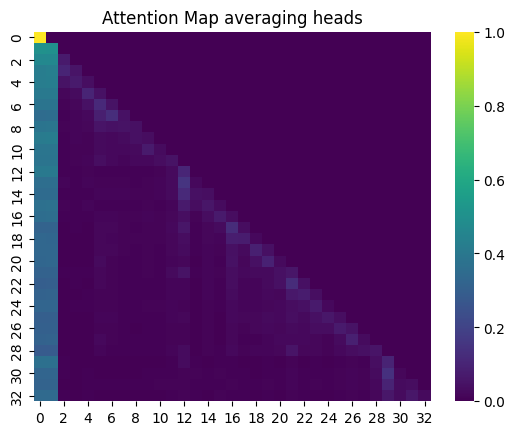

In [ ]:
# Show the attentions on the input
input_sequence_idx = 0
hidden_layer_idx = 0
input_attn = attentions[0][hidden_layer_idx][input_sequence_idx].mean(dim=0).detach().cpu()  # Mean across all heads
print(f'input_attn: {type(input_attn)}[{input_attn.shape}]')

sns.heatmap(input_attn, cmap='viridis', cbar=True)
plt.title(f'Attention Map averaging heads')
plt.show()

# Analyze Llama hidden states

In [ ]:
class LlamaHiddenStatesExtractor:
    """
    Class to extract hidden states from the Llama model.
    """
    def __init__(self, llama: LlamaInstruct):
        self.llama = llama

    def extract_hidden_states(self, prompt, max_new_tokens=5, num_return_sequences=1, verbose: bool=False):

        if verbose:
          print('max_new_tokens:', max_new_tokens)
          print('Return sequences:', num_return_sequences)
          print('Llama num_heads:', self.llama._get_model_num_heads())
          print('Llama hidden_layers:', self.llama._get_model_hidden_layers())
          print(f'Prompt: {prompt}')

        # Tokenize the input prompt
        inputs, _ = self.llama.tokenize(list(prompt))
        if verbose:
          print(f'Encoded tokens shape: {inputs.input_ids.shape}')

        # Generate output using the Llama model with `output_hidden_states=True` to capture hidden states
        outputs = self.llama.generate(
            inputs,
            generate_args={
                "max_new_tokens": max_new_tokens,
                "max_length": None,
                "num_return_sequences": num_return_sequences,
                "output_hidden_states": True,  # Make sure to output hidden states
                "return_dict_in_generate": True,
            }
        )
        if verbose:
          print(f'Generated output shape: {outputs.sequences.shape}')

        # Extract the hidden states from the model outputs
        hidden_states = outputs.hidden_states  # This will return a tuple of tuples of hidden states in each layer for each generated token
        if verbose:
          assert all(len(hidden_states[0]) == len(hidden_state) for hidden_state in hidden_states)
          assert all(hidden_states[0][0].shape == hidden_substate.shape for hidden_substate in hidden_states[0])
          print(f'hidden_states[{len(hidden_states)}][{len(hidden_states[0])}][{hidden_states[0][0].shape}, {hidden_states[0][0].dtype}, {hidden_states[0][0].device}]')

        return hidden_states, outputs

In [ ]:
extractor = LlamaHiddenStatesExtractor(llama)
prompts = ["Hello, how are you? I am fine", "How old are you?"]
hidden_states, outputs = extractor.extract_hidden_states(prompts, verbose=True)

max_new_tokens: 5
Return sequences: 1
Llama num_heads: 32
Llama hidden_layers: 16
Prompt: ['Hello, how are you? I am fine', 'How old are you?']
Encoded tokens shape: torch.Size([2, 29])
Generated output shape: torch.Size([2, 34])
hidden_states[5][17][torch.Size([2, 29, 2048]), torch.float16, cuda:0]


# Define the SAPLMA Classifier

In [ ]:
class SAPLMAClassifier(nn.Module):
    """
      SAPLMA Classifier as defined in https://arxiv.org/pdf/2304.13734
    """
    def __init__(self, input_size):
        super(SAPLMAClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.classifier(x)


In [ ]:
model = SAPLMAClassifier(input_size=2048).to("cuda")

## Load the true/false dataset

In [ ]:
class StatementDataset(Dataset):
    """
    PyTorch Dataset for statements and their truth values.
    """
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): The combined dataset from all CSV files.
                                      Expects columns ['statement', 'label', 'topic'].
        """
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the row to retrieve.

        Returns:
            tuple: (statement, label, topic), where statement is the text,
                   label is the binary target, and topic is the source file name.
        """
        row = self.data.iloc[idx]
        statement = row['statement']
        label = torch.tensor(row['label'])
        topic = row['topic']
        return statement, label, topic


def create_dataset_with_topics(drive_path):
    """
    Create a StatementDataset from CSV files in a specified Google Drive folder,
    adding a 'topic' column to indicate the source file of each row.

    Args:
        drive_path (str): Path to the folder containing the CSV files.

    Returns:
        StatementDataset: PyTorch Dataset for the combined dataset.
    """
    # Ensure the path exists
    if not os.path.exists(drive_path):
        raise ValueError(f"Path '{drive_path}' does not exist.")

    all_dataframes = []
    for file_name in os.listdir(drive_path):
        file_path = os.path.join(drive_path, file_name)
        if file_name.endswith(".csv"):
            print(f"Loading file: {file_name}")
            # Read the CSV and add a 'topic' column with the file name (without extension)
            df = pd.read_csv(file_path)
            df['topic'] = os.path.splitext(file_name)[0]  # Add topic column
            all_dataframes.append(df)

    if all_dataframes:
        combined_dataset = pd.concat(all_dataframes, ignore_index=True)
    else:
        raise ValueError(f"No CSV files found in the directory '{drive_path}'.")

    # Create and return the PyTorch Dataset
    return StatementDataset(combined_dataset)

In [ ]:
datasetPath = os.path.join(DRIVE_PATH, "publicDataset")

dataset = create_dataset_with_topics(datasetPath)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
# Iterate through the DataLoader
for statements, labels, topics  in dataloader:
    print("Statements:", statements)
    print("Labels:", labels)
    print("Labels type:", type(labels[0].item()))
    print("Topics:", topics)
    break


Loading file: cities_true_false.csv
Loading file: animals_true_false.csv
Loading file: elements_true_false.csv
Loading file: inventions_true_false.csv
Loading file: companies_true_false.csv
Loading file: generated_true_false.csv
Loading file: facts_true_false.csv
Statements: ('James Hargreaves invented the U.S.', 'Paris is a city in France', 'Xenon has the symbol Xe.', 'Birds can fly.')
Labels: tensor([0, 1, 1, 1])
Labels type: <class 'int'>
Topics: ('inventions_true_false', 'cities_true_false', 'elements_true_false', 'facts_true_false')


In [ ]:
def split_dataset_by_topic(dataset: StatementDataset) -> dict[str, tuple[StatementDataset, StatementDataset]]:
    """
    Splits the dataset for leave-one-topic-out cross-validation.

    Args:
        dataset (StatementDataset): The full dataset to split.

    Returns:
        dict: A dictionary where keys are topic names, and values are tuples (train_set, test_set).
              train_set and test_set are StatementDataset instances.
    """
    # Extract the underlying DataFrame
    dataframe = dataset.data

    # Get unique topics
    topics = dataframe['topic'].unique()
    split_data = {}

    for topic in topics:
        # Split data into training and testing sets
        test_data = dataframe[dataframe['topic'] == topic]
        train_data = dataframe[dataframe['topic'] != topic]

        # Create datasets
        train_set = StatementDataset(train_data.reset_index(drop=True))
        test_set = StatementDataset(test_data.reset_index(drop=True))

        # Store the split
        split_data[topic] = (train_set, test_set)

    return split_data


In [ ]:
split_data = split_dataset_by_topic(dataset)

for topic, (train_set, test_set) in split_data.items():
    print(f"Topic: {topic}")
    print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")


Topic: cities_true_false
Train size: 4872, Test size: 1458
Topic: animals_true_false
Train size: 5322, Test size: 1008
Topic: elements_true_false
Train size: 5400, Test size: 930
Topic: inventions_true_false
Train size: 5454, Test size: 876
Topic: companies_true_false
Train size: 5130, Test size: 1200
Topic: generated_true_false
Train size: 6085, Test size: 245
Topic: facts_true_false
Train size: 5717, Test size: 613


In [ ]:
def mean_of_last_tensors_of_each_token(hidden_states, layer_idx):
    """
    Compute the mean of the hidden states output by the LLM, referring to each input token
    """

    # Take only the first forward pass
    first_forward_pass = hidden_states[0]

    # Take the n-th layer hidden state
    n_th_layer_hidden_states = first_forward_pass[layer_idx]

    # For each sentence in the batch, take the hidden state referring to ALL token in the input sequence
    all_token_hidden_states = n_th_layer_hidden_states.mean(dim=1)

    return all_token_hidden_states

mean_of_last_tensors_of_each_token(hidden_states, layer_idx=8).shape

torch.Size([2, 2048])

In [ ]:
def get_last_input_token_states(hidden_states, layer_idx):
    """
    Given the hidden states,
    return the ones referring to the last token in the input sequence
    in the n-th layer specified.
    """

    # Take only the first forward pass, containing only input items at this point
    first_forward_pass = hidden_states[0]

    # Take the n-th layer hidden state
    n_th_layer_hidden_states = first_forward_pass[layer_idx]

    # For each sentence in the batch, take the hidden state referring to ONLY THE LAST token in the input sequence
    last_token_hidden_states = n_th_layer_hidden_states[:, -1, :]

    return last_token_hidden_states

assert not torch.equal(
    mean_of_last_tensors_of_each_token(hidden_states, layer_idx=8),
    get_last_input_token_states(hidden_states, layer_idx=8),
)

get_last_input_token_states(hidden_states, layer_idx=8).shape

torch.Size([2, 2048])

### Observe if LLM output is non-deterministic

In case the LLM output is deterministic between different runs given the same input sequences, we can easily make the training loop lighter. Indeed, we can save the pre-computed tensors for each input sentence, so that the LLM inference can be skipped in the training loop.

This may allow us to run the project on CPU, saving GPU resources on pay-per-use platforms such as Google Colab.

In [ ]:
def see_saplma_training_loop_data(hallucination_classifier: nn.Module,
                      dataset: torch.utils.data.Dataset,
                      llm: LlamaInstruct,
                      last_input_hidden_state_layer_idx: int,
                      batch_size: int = 32,
                      epochs: int = 5,
                      learning_rate: float = 1e-4,
                  ) -> nn.Module:

    # Move model to device
    hallucination_classifier = hallucination_classifier.to(device)
    hallucination_classifier.train()

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    first_batch = next(iter(dataloader))

    first_result = None

    for _ in range(20):
      statements, labels, _ = first_batch

      extractor = LlamaHiddenStatesExtractor(llama)

      labels = labels.to(device)

      with torch.no_grad():
        hidden_states, _ = extractor.extract_hidden_states(statements)

      last_token_state = get_last_input_token_states(hidden_states, layer_idx=last_input_hidden_state_layer_idx)
      if first_result is None:
        first_result = last_token_state
      else:
        print(torch.norm(last_token_state - first_result).detach().cpu().item())

In [ ]:
test_topic = 'cities_true_false'  #@param {type:'string'}
last_input_hidden_state_layer_idx = 12  #@param {type:'integer', min:0, max:16}
train_set, test_set = split_dataset_by_topic(dataset)[test_topic]

see_saplma_training_loop_data(
    hallucination_classifier=model,
    dataset=train_set,
    llm=llama,
    last_input_hidden_state_layer_idx=last_input_hidden_state_layer_idx,
    batch_size=4,
    epochs=1,
    learning_rate=1e-4,
)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


We observe that the results are **deterministic**.

We can proceed creating a pre-computed tensors dataset to relieve the training loop.

This process now continues on the notebook **2**